# sPYcon Tutorial

sPYcon is a toolbox to easily use and benchmark connectivity inference algorthims. In the following basic functionalities are explained step by step.

In [1]:
# Basic imports
from matplotlib import pyplot
import numpy

## Inferring connectivity from spike trains 

First we need to load some spike data, which simple consists of two numpy arrays:

1. The spike times in seconds
2. The unit ids

That's already it.

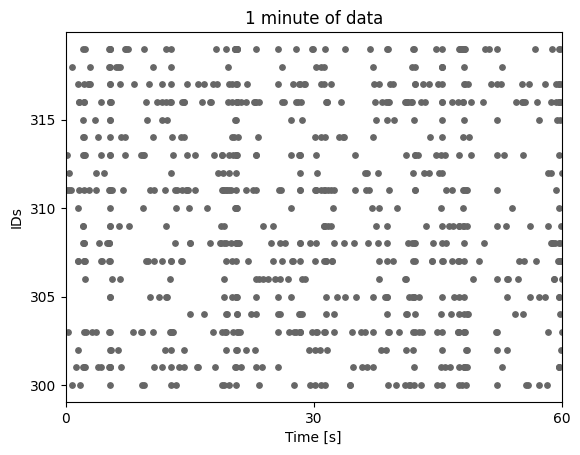

In [2]:
# change to a non ground truth data set

data = numpy.load('../data/gt_data/sim1917Cell1Block1_tiny.npz')
times, ids = data['times'], data['ids']
pyplot.scatter(times, ids, s=15, c=[[.4,.4,.4]])
pyplot.yticks(numpy.unique(ids)[::5])
pyplot.xlim([0,60])
pyplot.xticks([0,30,60])
pyplot.ylabel('IDs')
pyplot.xlabel('Time [s]')
pyplot.title('1 minute of data')
pyplot.show()

As a next step we import the connectivity inference method in question and infer the connectivity. This will return a results object, that contains all the information of the inferred graph.

In [3]:
from spycon.coninf import Smoothed_CCG
con_method = Smoothed_CCG({'alpha': 0.01})
spycon_result = con_method.infer_connectivity(times, ids)

Using cpu device


100%|██████████| 380/380 [00:07<00:00, 47.65it/s]


The graph can also be plotted easily, as well as the graph, which contains the decision statistics for each edge.

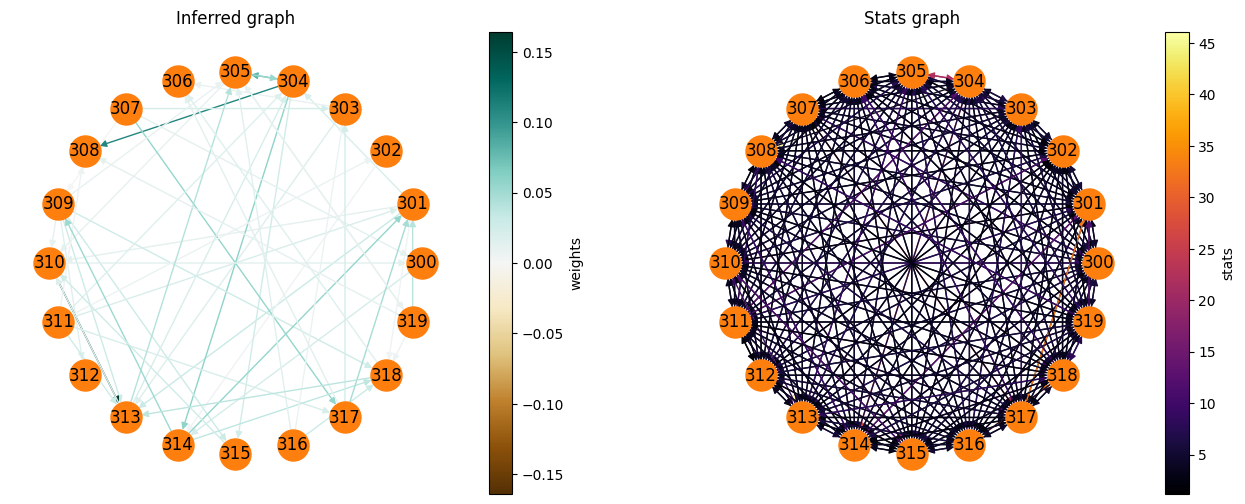

In [4]:
fig = pyplot.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
spycon_result.draw_graph(graph_type='weighted', ax=ax1)
ax1.set_title('Inferred graph')
ax2 = fig.add_subplot(122)
spycon_result.draw_graph(graph_type='stats', ax=ax2)
ax2.set_title('Stats graph')
pyplot.show()

## Testing an inference algorithm

Now we wish to evaluate an algorithm. For that we load a test, that contains

1. Spike times & Unit ids (i.e. spiking data)
2. A binary ground truth graph, which we can compare against.

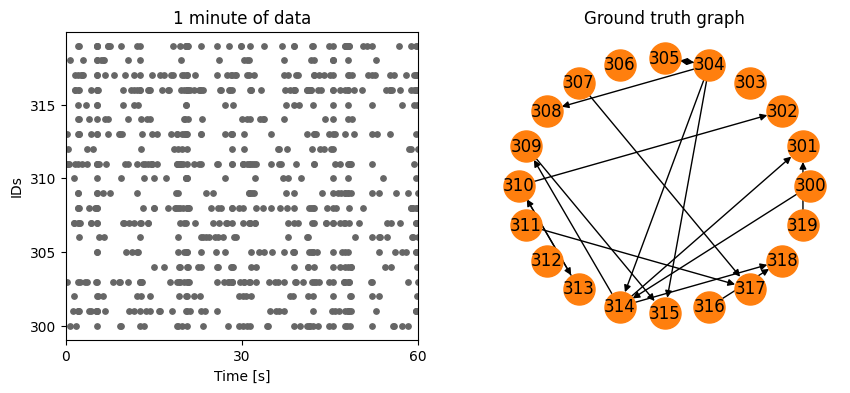

In [5]:
from spycon.spycon_tests import load_test
spycon_test = load_test(name='sim1917Cell1Block1_tiny', path='../data/gt_data/')

pyplot.figure(figsize=(10,4))
pyplot.subplot(121)
pyplot.scatter(times, ids, s=15, c=[[.4,.4,.4]])
pyplot.yticks(numpy.unique(ids)[::5])
pyplot.xlim([0,60])
pyplot.xticks([0,30,60])
pyplot.ylabel('IDs')
pyplot.xlabel('Time [s]')
pyplot.title('1 minute of data')
pyplot.subplot(122)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
pyplot.show()

We can simply run the test for an inference algorithm by one line, which will return us certain metrics. If indicated it also returns the sPYcon result object.

In [6]:
spycon_result, test_metrics = spycon_test.run_test(con_method, only_metrics=False, parallel=False,)

100%|██████████| 380/380 [00:07<00:00, 48.16it/s]


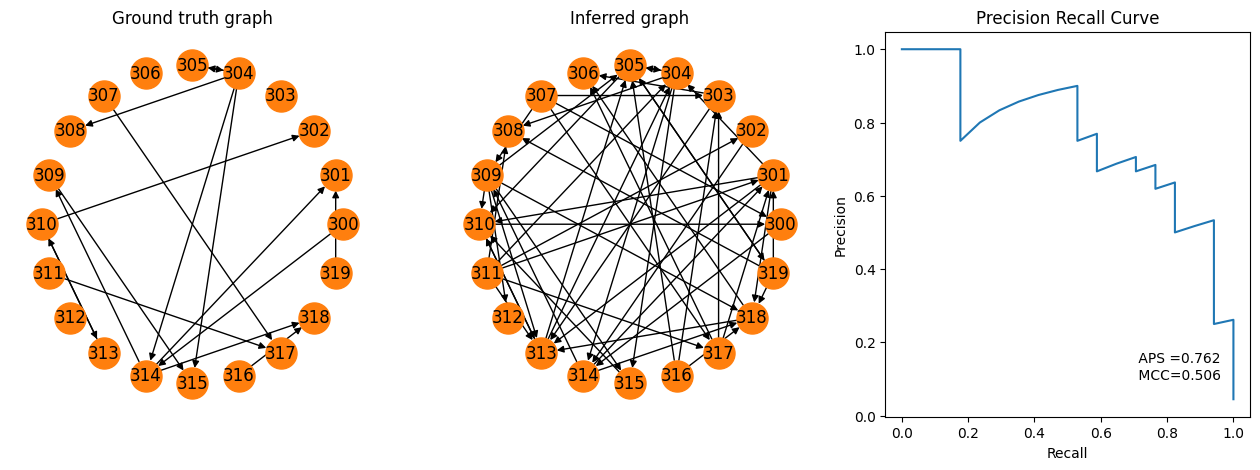

In [7]:
fig = pyplot.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
ax2 = fig.add_subplot(132)
spycon_result.draw_graph(graph_type='binary', ax=ax2)
pyplot.title('Inferred graph')
ax3 = fig.add_subplot(133)
recall, precision, aps, mcc = tuple(test_metrics[['prc_recall', 'prc_precision', 'aps', 'mcc']].to_numpy()[0])
pyplot.plot(recall, precision)
pyplot.text(.7,.1,f' APS ={aps:.3f} \n MCC={mcc:.3f}')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision Recall Curve')
pyplot.show()

Now we can easily visualize the true and the inferred graph. In addition, the metrics allow us for example to plot the recall-precision curve and to assess average precision score (APS).

## Benchmarking 

Before, we saw that the inferred graph contained most of the true connections, but had many 'false postive' edges. We wish to investigate now the effect of a single parameter in the connectivity procedure (the significance level $\alpha$) on different metrics. For this we create a benchmark object, that can take several inference objects with different parametrizations, as well as different tests (here we only take 1 test).

In [8]:
from spycon.benchmark import ConnectivityBenchmark
test_names = [('sim1917Cell1Block1_tiny', {})]
alphas = [.5e-3, 1e-3, .5e-2, 1e-2]
coninf_list = []
for alpha in alphas:
    coninf_list.append(('sccg', {'alpha': alpha}))
spycon_benchmark = ConnectivityBenchmark(name='alpha benchmark', data_sets=test_names, methods=coninf_list, data_path='../data/gt_data/')
benchmark_results = spycon_benchmark.run_benchmarks()

+----------------------------------------------+
0 of 4 tests: Currently method 'sccg' with dataset 'sim1917Cell1Block1_tiny'
+----------------------------------------------+


100%|██████████| 380/380 [00:08<00:00, 46.51it/s]


+----------------------------------------------+
1 of 4 tests: Currently method 'sccg' with dataset 'sim1917Cell1Block1_tiny'
+----------------------------------------------+


100%|██████████| 380/380 [00:07<00:00, 47.61it/s]


+----------------------------------------------+
2 of 4 tests: Currently method 'sccg' with dataset 'sim1917Cell1Block1_tiny'
+----------------------------------------------+


100%|██████████| 380/380 [00:09<00:00, 41.04it/s]


+----------------------------------------------+
3 of 4 tests: Currently method 'sccg' with dataset 'sim1917Cell1Block1_tiny'
+----------------------------------------------+


100%|██████████| 380/380 [00:08<00:00, 43.02it/s]


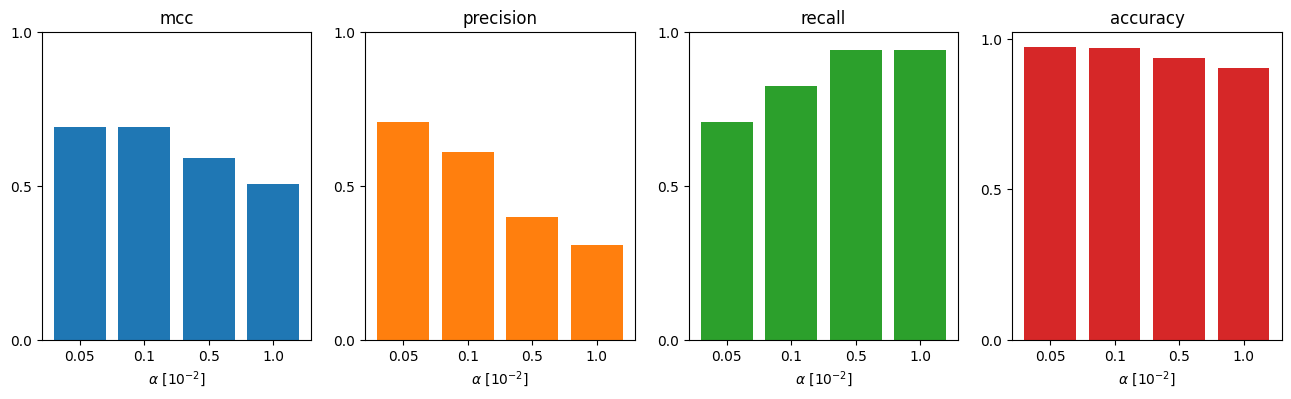

In [9]:
pyplot.figure(figsize=(16,4))
metric_names = ['mcc', 'precision', 'recall', 'accuracy']
for iplot, metric_name in enumerate(metric_names):
    ax = pyplot.subplot(1, len(metric_names), iplot+1)
    ax.bar(range(len(alphas)), benchmark_results[metric_name], color='C%d' %iplot)
    ax.set_xticks(range(len(alphas)), labels=numpy.array(alphas) * 100)
    ax.set_xlabel('$\\alpha\ [10^{-2}]$')
    ax.set_title(metric_name)
    ax.set_yticks([0,.5,1])

From the fact, that the precision drops drastically, if we increase alpha (as well as matthew's correlation coefficient (MCC) and accuracy), we can conclude, that the standard threshold ($\alpha=0.01$) is too high. So let's rerun the test from earlier with a lower $\alpha=0.001$.

100%|██████████| 380/380 [00:08<00:00, 46.98it/s]


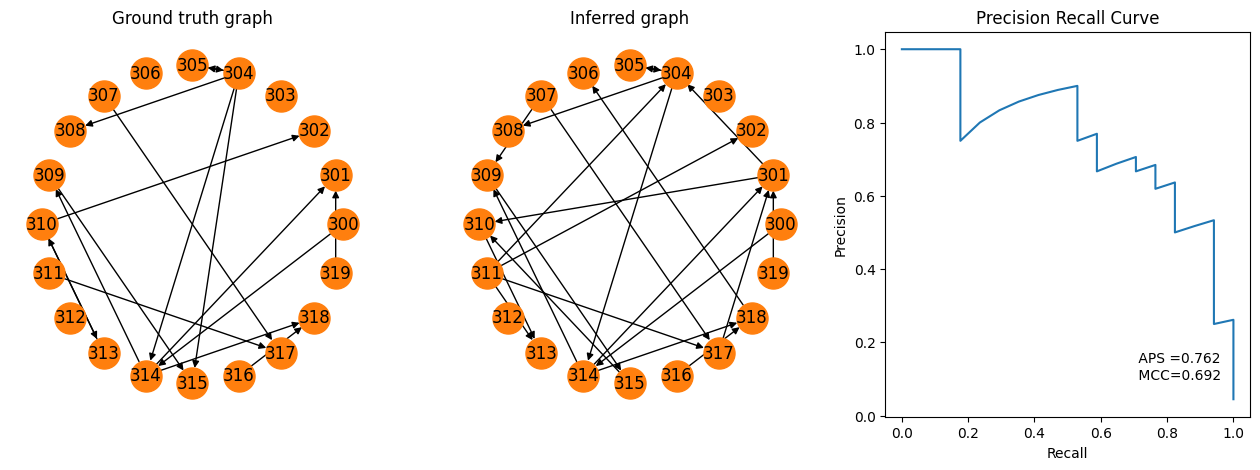

In [10]:
coninf = Smoothed_CCG({'alpha': .001})
spycon_result, test_metrics = spycon_test.run_test(coninf, only_metrics=False)
fig = pyplot.figure(figsize=(16,5))
ax1 = fig.add_subplot(131)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
ax2 = fig.add_subplot(132)
spycon_result.draw_graph(graph_type='binary', ax=ax2)
pyplot.title('Inferred graph')
ax3 = fig.add_subplot(133)
recall, precision, aps, mcc = tuple(test_metrics[['prc_recall', 'prc_precision', 'aps', 'mcc']].to_numpy()[0])
pyplot.plot(recall, precision)
pyplot.text(.7,.1,f' APS ={aps:.3f} \n MCC={mcc:.3f}')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision Recall Curve')
pyplot.show()

Even though, the inference is still not perfect, we got rid of many more false positives. Note, that the MCC also increased. The recall precision curve and APS did not change, since they are invariant to threshold parameters like $\alpha$. That is why these might be preferred metrics for comparing different algorithms when one wants to evaluate the algorithms independent of the threshold selection.